# Di Tella 2017
This file replicates the results from [Di Tella 2017, Uncertainty Shocks and Balance Sheet Recessions](https://gsb-faculty.stanford.edu/sebastian-di-tella/files/2022/10/DiTella_Unc_Shocks_2556027.pdf)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    # variables
    r"\iota": "iota",
    r"\hat{e}": "e_hat",
    r"\hat{c}": "c_hat",
    r"\sigma_{x,1}": "sigxtop",
    r"\sigma_{x,2}": "sigxbot",
    r"\sigma_x": "sigx",
    r"\sigma_p": "sigp",
    r"\sigma_\xi": "sigxi",
    r"\sigma_\zeta": "sigzeta",
    r"\tilde{\sigma_n}": "signtilde",
    r"\sigma_n": "sign",
    r"\pi": "signxi",
    r"\sigma_w": "sigw",
    r"\mu_n": "mun",
    r"\mu_x": "mux",
    r"\mu_p": "mup",
    r"\mu_\xi": "muxi",
    r"\mu_\zeta": "muzeta",
    r"\mu_w": "muw",

    # agents
    r"\xi": "xi",
    r"\zeta": "zeta",

    # constants
    r"\bar{\sigma_v}": "sigv_mean",
    r"\sigma_v": "sigv",
    r"\mu_v": "muv",
    r"\sigma": "sigma",
    r"\lambda": "lbd",
    r"\bar{v}": "v_mean",
    r"\rho": "rho",
    r"\gamma": "gamma",
    r"\psi": "psi",
    r"\tau": "tau",
    r"\delta": "delta",
    r"\phi": "phi",
}
MODEL_DIR = "./models/ditella_lb"

In [3]:
set_seeds(0)
pde_model = PDEModelTimeStep("ditella", 
                     {"batch_size": 500, "time_batch_size": 1, "sampling_method": SamplingMethod.UniformRandom, 
                      "num_outer_iterations": 50, "num_inner_iterations": 5000,
                      "loss_balancing": True}, 
                     latex_var_mapping)
pde_model.set_state(["x", "v"], {"x": [0.05, 0.95], "v": [0.05, 0.95]})
pde_model.add_agents(["xi", "zeta"], 
                     {"xi": {
                         "positive": True, 
                        }, 
                      "zeta": {
                          "positive": True, 
                          }
                     })
pde_model.add_endogs(["p", "r"], 
                     {"p": {
                         "positive": True, 
                         },
                     })
# pde_model.set_initial_guess({"p": 7.0})
pde_model.add_params({
    "a": 1,
    "sigma": 0.0125,
    "lbd": 1.38,
    "v_mean": 0.25,
    "sigv_mean": -0.17,
    "rho": 0.0665,
    "gamma": 5,
    "psi": 0.5,
    "tau": 1.15,
    "phi": 0.2,

    "A": 53.2,
    "B": -0.8668571428571438,
    "delta": 0.05,
})
pde_model.add_equation(r"$g &= \frac{1}{2*A} * (p - B) - \delta$") # g &= \frac{1}{2*A} * (p - B) - \delta
pde_model.add_equation(r"$\iota &= A * (g+\delta)^2 + B * (g+\delta)$") # \iota &= A * (g+\delta)^2 + B * (g+\delta)
pde_model.add_equation(r"$\mu_v &= \lambda * (\bar{v} - v)$")
pde_model.add_equation(r"$\sigma_v &= \bar{\sigma_v} * \sqrt{v}$")
pde_model.add_equation(r"$\hat{e} &= \rho^{1/\psi} * \xi^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\hat{c} &= \rho^{1/\psi} * \zeta^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\sigma_{x,1} &= (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial v} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial v} \right)$")
pde_model.add_equation(r"$\sigma_{x,2} &= 1 - (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial x} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial x} \right)$")
pde_model.add_equation(r"$\sigma_x &= \frac{\sigma_{x,1}}{\sigma_{x,2}} * \sigma_v$")
pde_model.add_equation(r"$\sigma_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial v} * \sigma_v + \frac{\partial p}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial v} * \sigma_v + \frac{\partial \xi}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial v} * \sigma_v + \frac{\partial \zeta}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_n &= \sigma + \sigma_p + \frac{\sigma_x}{x}$")
pde_model.add_equation(r"$\pi &= \gamma * \sigma_n + (\gamma-1) * \sigma_\xi$")
pde_model.add_equation(r"$\sigma_w &= \frac{\pi}{\gamma} - \frac{\gamma-1}{\gamma} *  \sigma_\zeta$")
pde_model.add_equation(r"$\mu_w &= r + \pi * \sigma_w$")
pde_model.add_equation(r"$\mu_n &= r + \frac{\gamma}{x^2} * (\phi * v)^2 + \pi * \sigma_n$")
pde_model.add_equation(r"$\tilde{\sigma_n} &= \frac{\phi}{x} * v$")
pde_model.add_equation(r"$\mu_x &= x * \left(\mu_n - \hat{e} - \tau + \frac{a-\iota}{p} - r - \pi * (\sigma+\sigma_p) - \frac{\gamma}{x} * (\phi * v)^2 + (\sigma + \sigma_p)^2 - \sigma_n * (\sigma + \sigma_p)\right)$")
pde_model.add_equation(r"$\mu_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial t} + \mu_v * \frac{\partial p}{\partial v} + \mu_x * \frac{\partial p}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 p}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 p}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 p}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial t} + \mu_v * \frac{\partial \xi}{\partial v} + \mu_x * \frac{\partial \xi}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \xi}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \xi}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \xi}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial t} + \mu_v * \frac{\partial \zeta}{\partial v} + \mu_x * \frac{\partial \zeta}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \zeta}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \zeta}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \zeta}{\partial x^2} \right)\right)$")

pde_model.add_endog_equation(r"$a - \iota &= p * (\hat{e} * x + \hat{c} * (1-x))$")
pde_model.add_endog_equation(r"$\sigma + \sigma_p &= \sigma_n * x + \sigma_w * (1-x)$")
pde_model.add_endog_equation(r"$\frac{a-\iota}{p} + g + \mu_p + \sigma * \sigma_p - r &= (\sigma + \sigma_p) * \pi + \gamma * \frac{1}{x} * (\phi * v)^2$")

pde_model.add_hjb_equation(r"$\frac{\hat{e}^{1-\psi}}{1-\psi} * \rho * \xi^{\psi-1} + \frac{\tau}{1-\gamma} * \left(\left(\frac{\zeta}{\xi} \right)^{1-\gamma}-1 \right) + \mu_n - \hat{e} + \mu_\xi - \frac{\gamma}{2} * \left( \sigma_n^2 + \sigma_\xi^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_n * \sigma_\xi + \tilde{\sigma_n}^2 \right) - \frac{\rho}{1-\psi}$")
pde_model.add_hjb_equation(r"$\frac{\hat{c}^{1-\psi}}{1-\psi} * \rho * \zeta^{\psi-1} + \mu_w - \hat{c} + \mu_\zeta - \frac{\gamma}{2} * \left( \sigma_w^2 + \sigma_\zeta^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_w * \sigma_\zeta \right) - \frac{\rho}{1-\psi}$")
print(pde_model)
if not os.path.exists(f"{MODEL_DIR}/model.pt"):
    pde_model.train_model(MODEL_DIR, "model.pt", True)
    pde_model.load_model(torch.load(f"{MODEL_DIR}/model_best.pt", weights_only=False))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{MODEL_DIR}/model_best.pt", weights_only=False))
    pde_model.eval_model(True)

============================Summary of Model ditella============================
Config: {
 "batch_size": 500,
 "time_batch_size": 1,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001,
 "sampling_method": "UniformRandom",
 "refinement_rounds": 5,
 "loss_balancing": true,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999
}
Latex Variable Mapping:
{
 "\\iota": "iota",
 "\\hat{e}": "e_hat",
 "\\hat{c}": "c_hat",
 "\\sigma_{x,1}": "sigxtop",
 "\\sigma_{x,2}": "sigxbot",
 "\\sigma_x": "sigx",
 "\\sigma_p": "sigp",
 "\\sigma_\\xi": "sigxi",
 "\\sigma_\\zeta": "sigzeta",
 "\\tilde{\\sigma_n}": "signtilde",
 "\\sigma_n": "sign",
 "\\pi": "signxi",
 "\\sigma_w": "sigw",
 "\\mu_n": "mun",
 "\\mu_x": "mux",
 "\\mu_p": "mup",
 "\\mu_\\xi": "muxi",
 "\\mu_\\zeta": "muzeta",
 "\\mu_w": "muw",
 "\\xi": "xi",
 "\\zeta": "zeta",
 "\\bar{\\sigma_v}

Min loss: 0.1836: 100%|██████████| 5000/5000 [17:58<00:00,  4.63it/s]


Model loaded
xi: Mean Value: 0.10782, Absolute Change: 0.89218, Relative Change:  0.89218
zeta: Mean Value: 0.09244, Absolute Change: 0.90756, Relative Change:  0.90756
p: Mean Value: 10.86253, Absolute Change: 9.86253, Relative Change:  9.86253
r: Mean Value: 0.12566, Absolute Change: 0.87434, Relative Change:  0.87434
Updating min loss from inf to 0.1882
Outer Loop 0 Finished in 1078.8889s. Loading best model...


Min loss: 0.0029: 100%|██████████| 3535/3535 [12:44<00:00,  4.62it/s]


Model loaded
xi: Mean Value: 0.11210, Absolute Change: 0.00597, Relative Change:  0.05782
zeta: Mean Value: 0.09593, Absolute Change: 0.00498, Relative Change:  0.05338
p: Mean Value: 10.46075, Absolute Change: 0.42064, Relative Change:  0.03768
r: Mean Value: 0.05404, Absolute Change: 0.07410, Relative Change:  0.70764
Updating min loss from 0.1882 to 0.0030
Outer Loop 1 Finished in 764.6639s. Loading best model...


Min loss: 0.0008: 100%|██████████| 2886/2886 [10:35<00:00,  4.54it/s]


Model loaded
xi: Mean Value: 0.10039, Absolute Change: 0.01171, Relative Change:  0.10392
zeta: Mean Value: 0.08538, Absolute Change: 0.01055, Relative Change:  0.11071
p: Mean Value: 10.17292, Absolute Change: 0.28783, Relative Change:  0.02716
r: Mean Value: 0.03263, Absolute Change: 0.02266, Relative Change:  1.34246
Updating min loss from 0.0030 to 0.0010
Outer Loop 2 Finished in 635.1948s. Loading best model...


Min loss: 0.0004: 100%|██████████| 2500/2500 [09:04<00:00,  4.60it/s]


Model loaded
xi: Mean Value: 0.09326, Absolute Change: 0.00713, Relative Change:  0.07107
zeta: Mean Value: 0.07954, Absolute Change: 0.00584, Relative Change:  0.06811
p: Mean Value: 9.92404, Absolute Change: 0.24888, Relative Change:  0.02444
r: Mean Value: 0.03043, Absolute Change: 0.00531, Relative Change:  0.37995
Updating min loss from 0.0010 to 0.0004
Outer Loop 3 Finished in 544.0845s. Loading best model...


Min loss: 0.0004: 100%|██████████| 2236/2236 [08:13<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.08765, Absolute Change: 0.00560, Relative Change:  0.06003
zeta: Mean Value: 0.07478, Absolute Change: 0.00476, Relative Change:  0.05994
p: Mean Value: 9.73444, Absolute Change: 0.18960, Relative Change:  0.01906
r: Mean Value: 0.02042, Absolute Change: 0.01002, Relative Change:  0.71442
Updating min loss from 0.0004 to 0.0004
Outer Loop 4 Finished in 493.3117s. Loading best model...


Min loss: 0.0003: 100%|██████████| 2041/2041 [07:25<00:00,  4.58it/s]


Model loaded
xi: Mean Value: 0.08346, Absolute Change: 0.00420, Relative Change:  0.04789
zeta: Mean Value: 0.07143, Absolute Change: 0.00335, Relative Change:  0.04453
p: Mean Value: 9.54008, Absolute Change: 0.19435, Relative Change:  0.01997
r: Mean Value: 0.02205, Absolute Change: 0.00648, Relative Change:  0.65944
Updating min loss from 0.0004 to 0.0003
Outer Loop 5 Finished in 445.3467s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1889/1889 [06:54<00:00,  4.56it/s]


Model loaded
xi: Mean Value: 0.07907, Absolute Change: 0.00439, Relative Change:  0.05249
zeta: Mean Value: 0.06747, Absolute Change: 0.00396, Relative Change:  0.05547
p: Mean Value: 9.35337, Absolute Change: 0.18671, Relative Change:  0.01955
r: Mean Value: 0.00960, Absolute Change: 0.01245, Relative Change:  0.51466
Updating min loss from 0.0003 to 0.0002
Outer Loop 6 Finished in 414.3897s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1767/1767 [06:28<00:00,  4.55it/s]


Model loaded
xi: Mean Value: 0.07560, Absolute Change: 0.00347, Relative Change:  0.04392
zeta: Mean Value: 0.06447, Absolute Change: 0.00301, Relative Change:  0.04449
p: Mean Value: 9.17761, Absolute Change: 0.17576, Relative Change:  0.01881
r: Mean Value: 0.00700, Absolute Change: 0.00260, Relative Change:  0.08023
Updating min loss from 0.0002 to 0.0002
Outer Loop 7 Finished in 388.4075s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1666/1666 [06:09<00:00,  4.50it/s]


Model loaded
xi: Mean Value: 0.07249, Absolute Change: 0.00311, Relative Change:  0.04115
zeta: Mean Value: 0.06187, Absolute Change: 0.00259, Relative Change:  0.04028
p: Mean Value: 9.01102, Absolute Change: 0.16659, Relative Change:  0.01817
r: Mean Value: 0.00439, Absolute Change: 0.00269, Relative Change:  0.09636
Updating min loss from 0.0002 to 0.0002
Outer Loop 8 Finished in 369.8936s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1581/1581 [05:49<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.06967, Absolute Change: 0.00283, Relative Change:  0.03897
zeta: Mean Value: 0.05946, Absolute Change: 0.00241, Relative Change:  0.03875
p: Mean Value: 8.84228, Absolute Change: 0.16874, Relative Change:  0.01876
r: Mean Value: 0.00452, Absolute Change: 0.00258, Relative Change:  0.07443
Updating min loss from 0.0002 to 0.0002
Outer Loop 9 Finished in 349.2822s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1507/1507 [05:32<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.06693, Absolute Change: 0.00274, Relative Change:  0.03929
zeta: Mean Value: 0.05706, Absolute Change: 0.00240, Relative Change:  0.04039
p: Mean Value: 8.68644, Absolute Change: 0.15584, Relative Change:  0.01764
r: Mean Value: 0.00114, Absolute Change: 0.00338, Relative Change:  0.19531
Outer Loop 10 Finished in 332.7982s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1443/1443 [05:18<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.06463, Absolute Change: 0.00230, Relative Change:  0.03443
zeta: Mean Value: 0.05512, Absolute Change: 0.00194, Relative Change:  0.03392
p: Mean Value: 8.54152, Absolute Change: 0.14492, Relative Change:  0.01672
r: Mean Value: 0.00047, Absolute Change: 0.00247, Relative Change:  0.04505
Updating min loss from 0.0002 to 0.0001
Outer Loop 11 Finished in 318.6896s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1386/1386 [05:02<00:00,  4.59it/s]


Model loaded
xi: Mean Value: 0.06271, Absolute Change: 0.00192, Relative Change:  0.02970
zeta: Mean Value: 0.05355, Absolute Change: 0.00157, Relative Change:  0.02856
p: Mean Value: 8.43155, Absolute Change: 0.10997, Relative Change:  0.01286
r: Mean Value: -0.00453, Absolute Change: 0.00501, Relative Change:  0.37585
Updating min loss from 0.0001 to 0.0001
Outer Loop 12 Finished in 302.2832s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1336/1336 [04:55<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.06112, Absolute Change: 0.00159, Relative Change:  0.02536
zeta: Mean Value: 0.05214, Absolute Change: 0.00141, Relative Change:  0.02617
p: Mean Value: 8.31957, Absolute Change: 0.11199, Relative Change:  0.01330
r: Mean Value: -0.00397, Absolute Change: 0.00105, Relative Change:  0.02193
Updating min loss from 0.0001 to 0.0001
Outer Loop 13 Finished in 295.0439s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1290/1290 [04:46<00:00,  4.51it/s]


Model loaded
xi: Mean Value: 0.05952, Absolute Change: 0.00160, Relative Change:  0.02616
zeta: Mean Value: 0.05076, Absolute Change: 0.00138, Relative Change:  0.02652
p: Mean Value: 8.20709, Absolute Change: 0.11247, Relative Change:  0.01351
r: Mean Value: -0.00472, Absolute Change: 0.00141, Relative Change:  0.02402
Outer Loop 14 Finished in 286.3218s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1250/1250 [04:34<00:00,  4.55it/s]


Model loaded
xi: Mean Value: 0.05799, Absolute Change: 0.00153, Relative Change:  0.02572
zeta: Mean Value: 0.04951, Absolute Change: 0.00125, Relative Change:  0.02462
p: Mean Value: 8.09826, Absolute Change: 0.10884, Relative Change:  0.01327
r: Mean Value: -0.00679, Absolute Change: 0.00221, Relative Change:  0.10425
Outer Loop 15 Finished in 274.7760s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1212/1212 [04:24<00:00,  4.58it/s]


Model loaded
xi: Mean Value: 0.05671, Absolute Change: 0.00128, Relative Change:  0.02210
zeta: Mean Value: 0.04835, Absolute Change: 0.00116, Relative Change:  0.02334
p: Mean Value: 7.99963, Absolute Change: 0.09863, Relative Change:  0.01219
r: Mean Value: -0.00749, Absolute Change: 0.00071, Relative Change:  0.05158
Updating min loss from 0.0001 to 0.0001
Outer Loop 16 Finished in 264.6066s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1178/1178 [04:19<00:00,  4.54it/s]


Model loaded
xi: Mean Value: 0.05552, Absolute Change: 0.00119, Relative Change:  0.02101
zeta: Mean Value: 0.04740, Absolute Change: 0.00095, Relative Change:  0.01950
p: Mean Value: 7.92317, Absolute Change: 0.07646, Relative Change:  0.00956
r: Mean Value: -0.00984, Absolute Change: 0.00257, Relative Change:  0.13744
Outer Loop 17 Finished in 259.5913s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1147/1147 [04:14<00:00,  4.50it/s]


Model loaded
xi: Mean Value: 0.05469, Absolute Change: 0.00082, Relative Change:  0.01486
zeta: Mean Value: 0.04670, Absolute Change: 0.00071, Relative Change:  0.01488
p: Mean Value: 7.85980, Absolute Change: 0.06337, Relative Change:  0.00802
r: Mean Value: -0.00973, Absolute Change: 0.00105, Relative Change:  0.02871
Outer Loop 18 Finished in 254.8932s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1118/1118 [04:02<00:00,  4.61it/s]


Model loaded
xi: Mean Value: 0.05395, Absolute Change: 0.00075, Relative Change:  0.01365
zeta: Mean Value: 0.04609, Absolute Change: 0.00061, Relative Change:  0.01305
p: Mean Value: 7.79599, Absolute Change: 0.06381, Relative Change:  0.00812
r: Mean Value: -0.01046, Absolute Change: 0.00115, Relative Change:  0.06411
Updating min loss from 0.0001 to 0.0001
Outer Loop 19 Finished in 242.3655s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1091/1091 [04:01<00:00,  4.52it/s]


Model loaded
xi: Mean Value: 0.05314, Absolute Change: 0.00081, Relative Change:  0.01500
zeta: Mean Value: 0.04536, Absolute Change: 0.00073, Relative Change:  0.01586
p: Mean Value: 7.73343, Absolute Change: 0.06257, Relative Change:  0.00802
r: Mean Value: -0.01253, Absolute Change: 0.00213, Relative Change:  0.05613
Updating min loss from 0.0001 to 0.0001
Outer Loop 20 Finished in 241.2391s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1066/1066 [03:54<00:00,  4.55it/s]


Model loaded
xi: Mean Value: 0.05236, Absolute Change: 0.00078, Relative Change:  0.01466
zeta: Mean Value: 0.04467, Absolute Change: 0.00069, Relative Change:  0.01515
p: Mean Value: 7.67391, Absolute Change: 0.05952, Relative Change:  0.00768
r: Mean Value: -0.01441, Absolute Change: 0.00189, Relative Change:  0.07758
Outer Loop 21 Finished in 234.1108s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1042/1042 [03:52<00:00,  4.48it/s]


Model loaded
xi: Mean Value: 0.05174, Absolute Change: 0.00062, Relative Change:  0.01180
zeta: Mean Value: 0.04421, Absolute Change: 0.00046, Relative Change:  0.01029
p: Mean Value: 7.62218, Absolute Change: 0.05173, Relative Change:  0.00675
r: Mean Value: -0.01339, Absolute Change: 0.00166, Relative Change:  0.05176
Outer Loop 22 Finished in 232.5809s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1020/1020 [03:46<00:00,  4.50it/s]


Model loaded
xi: Mean Value: 0.05116, Absolute Change: 0.00058, Relative Change:  0.01137
zeta: Mean Value: 0.04365, Absolute Change: 0.00056, Relative Change:  0.01257
p: Mean Value: 7.55896, Absolute Change: 0.06322, Relative Change:  0.00833
r: Mean Value: -0.01251, Absolute Change: 0.00101, Relative Change:  0.19218
Updating min loss from 0.0001 to 0.0001
Outer Loop 23 Finished in 226.5395s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]


Model loaded
xi: Mean Value: 0.05041, Absolute Change: 0.00074, Relative Change:  0.01448
zeta: Mean Value: 0.04308, Absolute Change: 0.00057, Relative Change:  0.01319
p: Mean Value: 7.51602, Absolute Change: 0.04294, Relative Change:  0.00565
r: Mean Value: -0.01569, Absolute Change: 0.00318, Relative Change:  0.07423
Outer Loop 24 Finished in 222.2607s. Loading best model...


Min loss: 0.0001: 100%|██████████| 980/980 [03:34<00:00,  4.56it/s]


Model loaded
xi: Mean Value: 0.05000, Absolute Change: 0.00041, Relative Change:  0.00814
zeta: Mean Value: 0.04267, Absolute Change: 0.00040, Relative Change:  0.00931
p: Mean Value: 7.47003, Absolute Change: 0.04599, Relative Change:  0.00613
r: Mean Value: -0.01536, Absolute Change: 0.00083, Relative Change:  0.04129
Outer Loop 25 Finished in 214.9498s. Loading best model...


Min loss: 0.0001: 100%|██████████| 962/962 [03:32<00:00,  4.54it/s]


Model loaded
xi: Mean Value: 0.04950, Absolute Change: 0.00050, Relative Change:  0.00999
zeta: Mean Value: 0.04230, Absolute Change: 0.00037, Relative Change:  0.00875
p: Mean Value: 7.43199, Absolute Change: 0.03804, Relative Change:  0.00511
r: Mean Value: -0.01502, Absolute Change: 0.00063, Relative Change:  0.01683
Outer Loop 26 Finished in 212.0434s. Loading best model...


Min loss: 0.0001: 100%|██████████| 944/944 [03:26<00:00,  4.56it/s]


Model loaded
xi: Mean Value: 0.04909, Absolute Change: 0.00041, Relative Change:  0.00831
zeta: Mean Value: 0.04190, Absolute Change: 0.00040, Relative Change:  0.00951
p: Mean Value: 7.39012, Absolute Change: 0.04188, Relative Change:  0.00563
r: Mean Value: -0.01500, Absolute Change: 0.00121, Relative Change:  0.07672
Updating min loss from 0.0001 to 0.0001
Outer Loop 27 Finished in 206.8584s. Loading best model...


Min loss: 0.0001: 100%|██████████| 928/928 [03:25<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.04860, Absolute Change: 0.00049, Relative Change:  0.00991
zeta: Mean Value: 0.04155, Absolute Change: 0.00034, Relative Change:  0.00819
p: Mean Value: 7.35443, Absolute Change: 0.03569, Relative Change:  0.00483
r: Mean Value: -0.01513, Absolute Change: 0.00128, Relative Change:  0.05176
Outer Loop 28 Finished in 205.0709s. Loading best model...


Min loss: 0.0001: 100%|██████████| 912/912 [03:21<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.04827, Absolute Change: 0.00033, Relative Change:  0.00690
zeta: Mean Value: 0.04134, Absolute Change: 0.00021, Relative Change:  0.00516
p: Mean Value: 7.32866, Absolute Change: 0.02577, Relative Change:  0.00350
r: Mean Value: -0.01599, Absolute Change: 0.00121, Relative Change:  0.16459
Outer Loop 29 Finished in 201.4535s. Loading best model...


Min loss: 0.0001: 100%|██████████| 898/898 [03:18<00:00,  4.51it/s]


Model loaded
xi: Mean Value: 0.04801, Absolute Change: 0.00026, Relative Change:  0.00548
zeta: Mean Value: 0.04111, Absolute Change: 0.00023, Relative Change:  0.00557
p: Mean Value: 7.30612, Absolute Change: 0.02254, Relative Change:  0.00308
r: Mean Value: -0.01521, Absolute Change: 0.00102, Relative Change:  0.02569
Outer Loop 30 Finished in 198.9686s. Loading best model...


Min loss: 0.0001: 100%|██████████| 883/883 [03:15<00:00,  4.51it/s]


Model loaded
xi: Mean Value: 0.04778, Absolute Change: 0.00023, Relative Change:  0.00475
zeta: Mean Value: 0.04087, Absolute Change: 0.00023, Relative Change:  0.00569
p: Mean Value: 7.27749, Absolute Change: 0.02863, Relative Change:  0.00391
r: Mean Value: -0.01563, Absolute Change: 0.00069, Relative Change:  0.04118
Updating min loss from 0.0001 to 0.0001
Outer Loop 31 Finished in 195.9722s. Loading best model...


Min loss: 0.0001: 100%|██████████| 870/870 [03:11<00:00,  4.53it/s]


Model loaded
xi: Mean Value: 0.04749, Absolute Change: 0.00029, Relative Change:  0.00604
zeta: Mean Value: 0.04062, Absolute Change: 0.00025, Relative Change:  0.00622
p: Mean Value: 7.25162, Absolute Change: 0.02586, Relative Change:  0.00355
r: Mean Value: -0.01589, Absolute Change: 0.00072, Relative Change:  0.01954
Outer Loop 32 Finished in 191.8780s. Loading best model...


Min loss: 0.0001: 100%|██████████| 857/857 [03:11<00:00,  4.47it/s]


Model loaded
xi: Mean Value: 0.04722, Absolute Change: 0.00026, Relative Change:  0.00561
zeta: Mean Value: 0.04041, Absolute Change: 0.00021, Relative Change:  0.00521
p: Mean Value: 7.22793, Absolute Change: 0.02369, Relative Change:  0.00329
r: Mean Value: -0.01637, Absolute Change: 0.00112, Relative Change:  0.06025
Outer Loop 33 Finished in 191.8316s. Loading best model...


Min loss: 0.0001: 100%|██████████| 845/845 [03:08<00:00,  4.49it/s]


Model loaded
xi: Mean Value: 0.04702, Absolute Change: 0.00020, Relative Change:  0.00425
zeta: Mean Value: 0.04024, Absolute Change: 0.00017, Relative Change:  0.00415
p: Mean Value: 7.21134, Absolute Change: 0.01664, Relative Change:  0.00229
r: Mean Value: -0.01692, Absolute Change: 0.00087, Relative Change:  0.13159
Outer Loop 34 Finished in 188.1356s. Loading best model...


Min loss: 0.0000: 100%|██████████| 833/833 [03:09<00:00,  4.40it/s]


Model loaded
xi: Mean Value: 0.04684, Absolute Change: 0.00018, Relative Change:  0.00393
zeta: Mean Value: 0.04014, Absolute Change: 0.00010, Relative Change:  0.00255
p: Mean Value: 7.19881, Absolute Change: 0.01252, Relative Change:  0.00174
r: Mean Value: -0.01806, Absolute Change: 0.00131, Relative Change:  0.09297
Updating min loss from 0.0001 to 0.0000
Outer Loop 35 Finished in 189.5069s. Loading best model...


Min loss: 0.0000: 100%|██████████| 821/821 [03:02<00:00,  4.50it/s]


Model loaded
xi: Mean Value: 0.04674, Absolute Change: 0.00010, Relative Change:  0.00217
zeta: Mean Value: 0.04007, Absolute Change: 0.00007, Relative Change:  0.00181
p: Mean Value: 7.18911, Absolute Change: 0.00970, Relative Change:  0.00135
r: Mean Value: -0.01765, Absolute Change: 0.00066, Relative Change:  0.04670
Updating min loss from 0.0000 to 0.0000
Outer Loop 36 Finished in 182.6501s. Loading best model...


Min loss: 0.0001: 100%|██████████| 811/811 [02:57<00:00,  4.56it/s]


Model loaded
xi: Mean Value: 0.04664, Absolute Change: 0.00010, Relative Change:  0.00219
zeta: Mean Value: 0.04004, Absolute Change: 0.00004, Relative Change:  0.00115
p: Mean Value: 7.18427, Absolute Change: 0.00542, Relative Change:  0.00074
r: Mean Value: -0.01759, Absolute Change: 0.00122, Relative Change:  0.04102
Outer Loop 37 Finished in 177.7943s. Loading best model...


Min loss: 0.0001: 100%|██████████| 800/800 [02:57<00:00,  4.51it/s]


Model loaded
xi: Mean Value: 0.04658, Absolute Change: 0.00007, Relative Change:  0.00144
zeta: Mean Value: 0.04000, Absolute Change: 0.00004, Relative Change:  0.00103
p: Mean Value: 7.17674, Absolute Change: 0.00753, Relative Change:  0.00104
r: Mean Value: -0.01767, Absolute Change: 0.00113, Relative Change:  0.04345
Outer Loop 38 Finished in 177.2533s. Loading best model...


Min loss: 0.0000: 100%|██████████| 790/790 [02:53<00:00,  4.55it/s]


Model loaded
xi: Mean Value: 0.04651, Absolute Change: 0.00007, Relative Change:  0.00145
zeta: Mean Value: 0.03989, Absolute Change: 0.00012, Relative Change:  0.00286
p: Mean Value: 7.16969, Absolute Change: 0.00705, Relative Change:  0.00098
r: Mean Value: -0.01754, Absolute Change: 0.00103, Relative Change:  0.03029
Updating min loss from 0.0000 to 0.0000
Outer Loop 39 Finished in 173.5825s. Loading best model...


Min loss: 0.0001: 100%|██████████| 780/780 [02:51<00:00,  4.54it/s]


Model loaded
xi: Mean Value: 0.04644, Absolute Change: 0.00007, Relative Change:  0.00154
zeta: Mean Value: 0.03991, Absolute Change: 0.00006, Relative Change:  0.00162
p: Mean Value: 7.17017, Absolute Change: 0.00365, Relative Change:  0.00051
r: Mean Value: -0.01768, Absolute Change: 0.00115, Relative Change:  0.07242
Outer Loop 40 Finished in 171.6883s. Loading best model...


Min loss: 0.0001: 100%|██████████| 771/771 [02:49<00:00,  4.55it/s]


Model loaded
xi: Mean Value: 0.04649, Absolute Change: 0.00005, Relative Change:  0.00099
zeta: Mean Value: 0.03993, Absolute Change: 0.00004, Relative Change:  0.00091
p: Mean Value: 7.16372, Absolute Change: 0.00644, Relative Change:  0.00091
r: Mean Value: -0.01697, Absolute Change: 0.00091, Relative Change:  0.02838
Outer Loop 41 Finished in 169.6045s. Loading best model...


Min loss: 0.0000: 100%|██████████| 762/762 [02:47<00:00,  4.54it/s]


Model loaded
xi: Mean Value: 0.04641, Absolute Change: 0.00008, Relative Change:  0.00169
zeta: Mean Value: 0.03985, Absolute Change: 0.00008, Relative Change:  0.00207
p: Mean Value: 7.15769, Absolute Change: 0.00610, Relative Change:  0.00085
r: Mean Value: -0.01742, Absolute Change: 0.00108, Relative Change:  0.04878
Updating min loss from 0.0000 to 0.0000
Outer Loop 42 Finished in 167.9312s. Loading best model...


Min loss: 0.0000: 100%|██████████| 753/753 [02:43<00:00,  4.61it/s]


Model loaded
xi: Mean Value: 0.04629, Absolute Change: 0.00012, Relative Change:  0.00265
zeta: Mean Value: 0.03969, Absolute Change: 0.00015, Relative Change:  0.00381
p: Mean Value: 7.14315, Absolute Change: 0.01454, Relative Change:  0.00204
r: Mean Value: -0.01697, Absolute Change: 0.00067, Relative Change:  0.03509
Updating min loss from 0.0000 to 0.0000
Outer Loop 43 Finished in 163.4465s. Loading best model...


Min loss: 0.0000: 100%|██████████| 745/745 [01:56<00:00,  6.39it/s]


Model loaded
xi: Mean Value: 0.04615, Absolute Change: 0.00014, Relative Change:  0.00306
zeta: Mean Value: 0.03963, Absolute Change: 0.00006, Relative Change:  0.00164
p: Mean Value: 7.13122, Absolute Change: 0.01193, Relative Change:  0.00167
r: Mean Value: -0.01773, Absolute Change: 0.00121, Relative Change:  0.13013
Outer Loop 44 Finished in 116.6224s. Loading best model...


Min loss: 0.0000: 100%|██████████| 737/737 [01:55<00:00,  6.40it/s]


Model loaded
xi: Mean Value: 0.04603, Absolute Change: 0.00011, Relative Change:  0.00234
zeta: Mean Value: 0.03955, Absolute Change: 0.00008, Relative Change:  0.00202
p: Mean Value: 7.12905, Absolute Change: 0.00610, Relative Change:  0.00086
r: Mean Value: -0.01936, Absolute Change: 0.00212, Relative Change:  0.04802
Outer Loop 45 Finished in 115.1096s. Loading best model...


Min loss: 0.0000: 100%|██████████| 729/729 [01:44<00:00,  6.95it/s]


Model loaded
xi: Mean Value: 0.04595, Absolute Change: 0.00008, Relative Change:  0.00173
zeta: Mean Value: 0.03944, Absolute Change: 0.00011, Relative Change:  0.00282
p: Mean Value: 7.11410, Absolute Change: 0.01495, Relative Change:  0.00211
r: Mean Value: -0.01815, Absolute Change: 0.00125, Relative Change:  0.05318
Outer Loop 46 Finished in 104.8804s. Loading best model...


Min loss: 0.0000: 100%|██████████| 721/721 [01:32<00:00,  7.79it/s]


Model loaded
xi: Mean Value: 0.04584, Absolute Change: 0.00011, Relative Change:  0.00250
zeta: Mean Value: 0.03935, Absolute Change: 0.00009, Relative Change:  0.00227
p: Mean Value: 7.10436, Absolute Change: 0.00974, Relative Change:  0.00137
r: Mean Value: -0.01898, Absolute Change: 0.00105, Relative Change:  0.05434
Outer Loop 47 Finished in 92.6043s. Loading best model...


Min loss: 0.0000: 100%|██████████| 714/714 [01:40<00:00,  7.09it/s]


Model loaded
xi: Mean Value: 0.04572, Absolute Change: 0.00012, Relative Change:  0.00254
zeta: Mean Value: 0.03924, Absolute Change: 0.00010, Relative Change:  0.00266
p: Mean Value: 7.09222, Absolute Change: 0.01215, Relative Change:  0.00171
r: Mean Value: -0.01796, Absolute Change: 0.00102, Relative Change:  0.04529
Updating min loss from 0.0000 to 0.0000
Outer Loop 48 Finished in 100.7245s. Loading best model...


Min loss: 0.0000: 100%|██████████| 707/707 [01:37<00:00,  7.28it/s]


Model loaded
xi: Mean Value: 0.04557, Absolute Change: 0.00015, Relative Change:  0.00330
zeta: Mean Value: 0.03914, Absolute Change: 0.00010, Relative Change:  0.00257
p: Mean Value: 7.08040, Absolute Change: 0.01181, Relative Change:  0.00166
r: Mean Value: -0.01887, Absolute Change: 0.00098, Relative Change:  0.08592
Outer Loop 49 Finished in 97.1215s. Loading best model...
training finished, total time :: 13697.89153766632
Best model saved to ./models/ditella_lb/model_best.pt if valid
Model saved to ./models/ditella_lb/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_xi_cond_time_boundary: 0.0000,
agent_zeta_cond_time_boundary: 0.0000,
endogvar_p_cond_time_boundary: 0.0001,
endogvar_r_cond_time_boundary: 0.0000,
total_loss: 0.0002


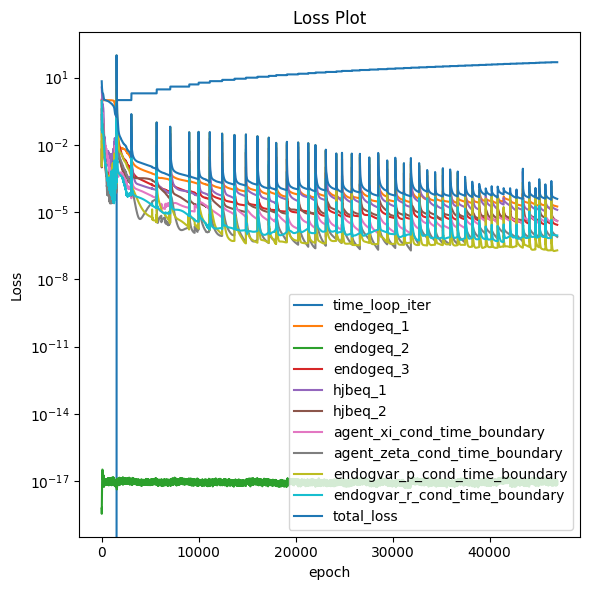

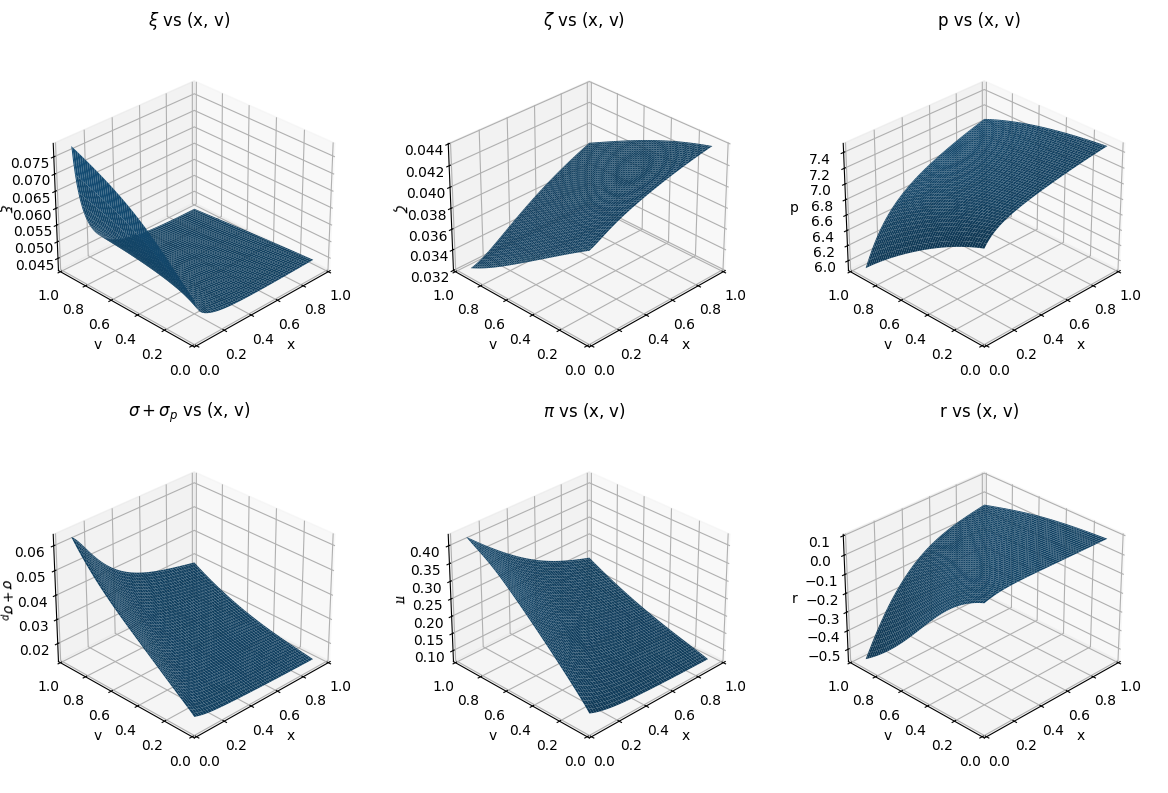

In [4]:
plot_loss_df(fn=f"{MODEL_DIR}/model_min_loss.csv", loss_plot_fn=f"{MODEL_DIR}/model_min_loss.png")
pde_model.plot_vars([r"$\xi$", r"$\zeta$", "p", 
                     r"$\sigma+\sigma_p = \sigma + \sigma_p$", r"$\pi$", "r"], ncols=3)

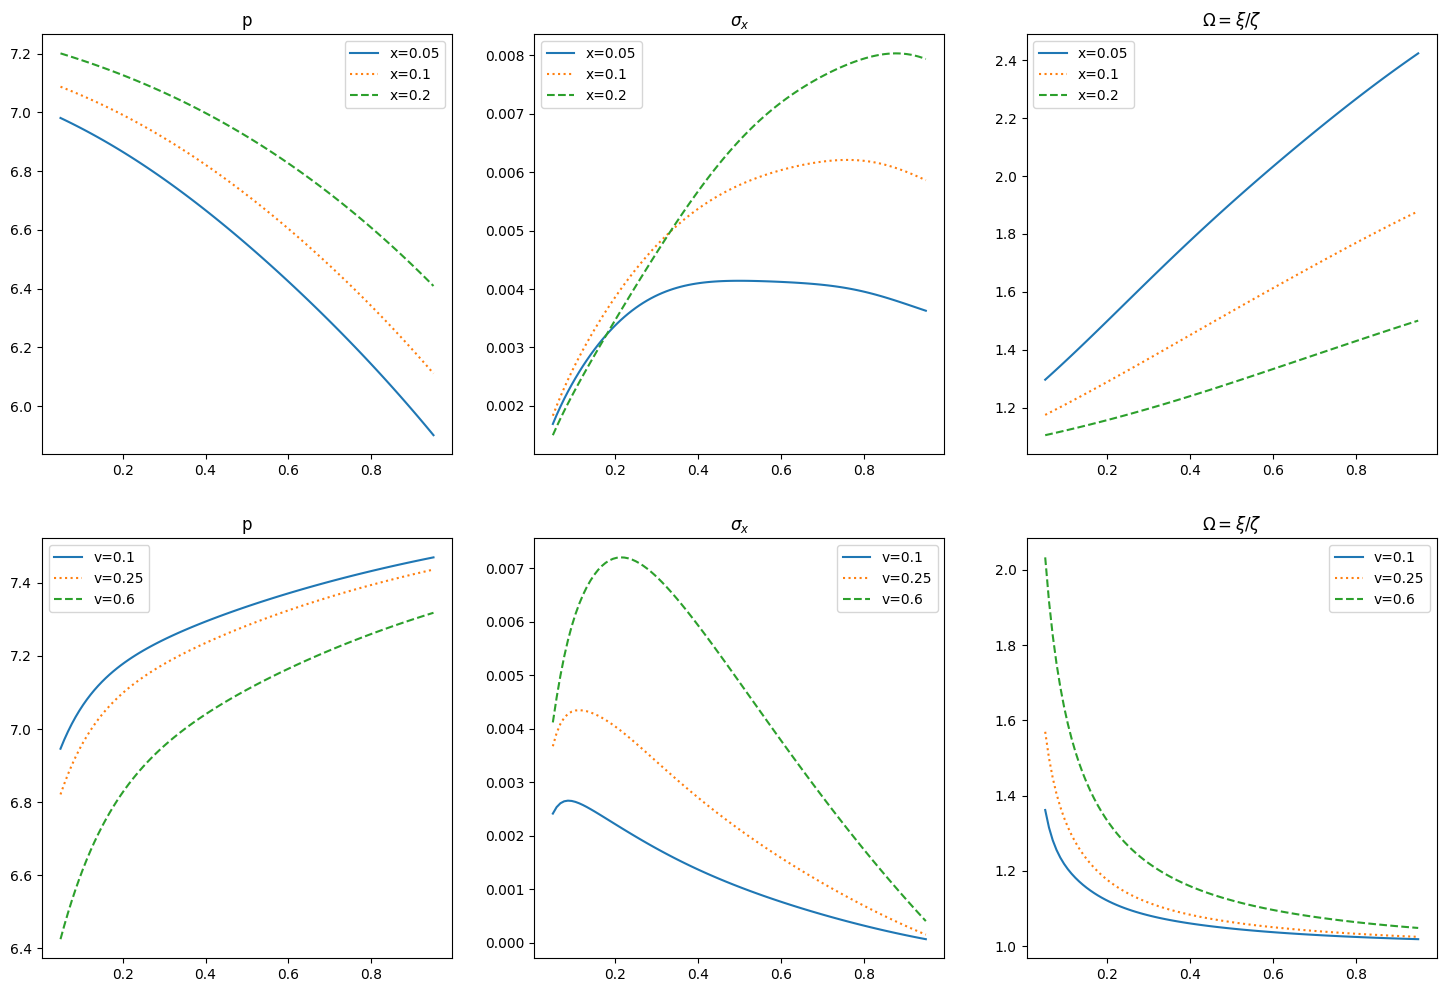

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"p")
    ax[0][1].set_title(r"$\sigma_x$")
    ax[0][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()

for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"p")
    ax[1][1].set_title(r"$\sigma_x$")
    ax[1][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()

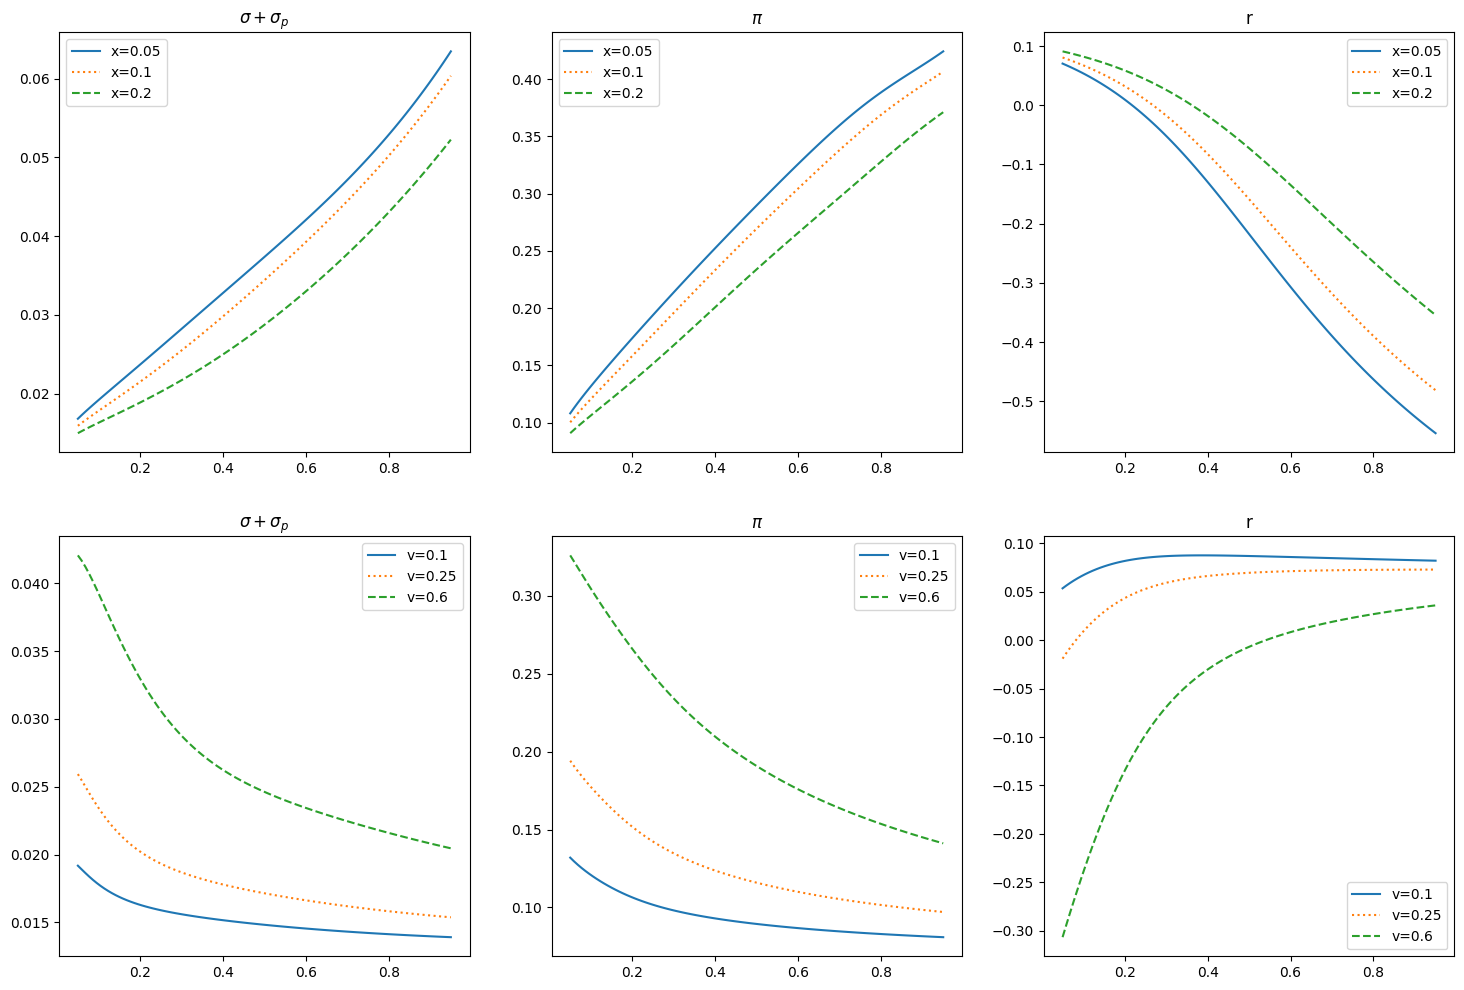

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"$\sigma+\sigma_p$")
    ax[0][1].set_title(r"$\pi$")
    ax[0][2].set_title("r")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()
for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"$\sigma+\sigma_p$")
    ax[1][1].set_title(r"$\pi$")
    ax[1][2].set_title("r")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()

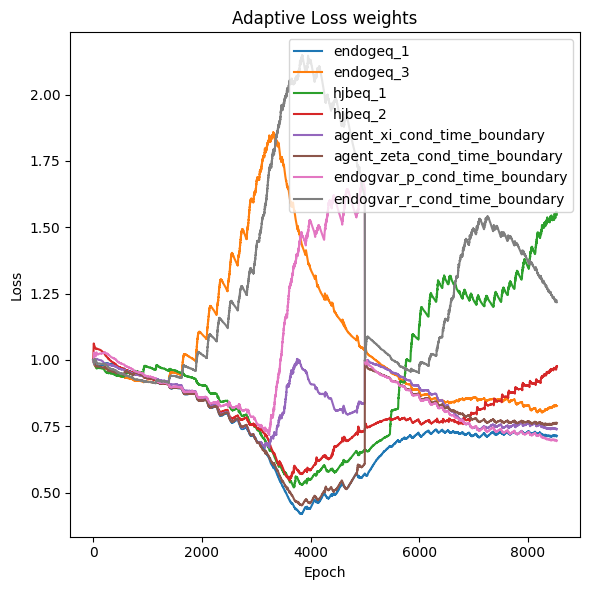

In [7]:
dfs = [pd.read_csv(f"{MODEL_DIR}/loss_weight_logs/model_loss_weight_{i}.csv").dropna().reset_index(drop=True) for i in range(2)]
loss_weight_df = pd.concat(dfs, axis=0).reset_index(drop=True)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
losses_to_plot = list(loss_weight_df.columns)
losses_to_plot.remove("outer_loop_iter")
losses_to_plot.remove("epoch")
losses_to_plot.remove("endogeq_2")
for loss in losses_to_plot:
    ax.plot(loss_weight_df.index, loss_weight_df[loss], label=loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Adaptive Loss weights")
plt.tight_layout()
plt.show()